### Section 1: Beginning stuff

#### 1.1 Importing packages

In [272]:
import rebound 

import sympy as sp
from matplotlib import pyplot as plt
from matplotlib import pyplot

import numpy as np

from sympy import init_printing
init_printing()

%matplotlib inline
from sympy import *

#### 1.2 Plot style 

In [273]:
# plot style and colour
plt.style.use('seaborn')
plt.rcParams['axes.facecolor'] = 'whitesmoke'

# plot border
plt.rcParams["axes.edgecolor"] = '0'
plt.rcParams["axes.linewidth"] = 0.7

#### 1.3  Unit conversion

In [274]:
rad_mas = 206264806
rad_as = 206264806/1000
as_mas = 1000
AU_pc = 4.84814e-6

#### 1.4 Initial conditions 

In [275]:
timescale = 4.2
m         = 200
times     = np.linspace(0,timescale,num = m)

In [276]:
# planet parameters 
inc           = 0                                             # orbital inclination                 [rad]
m_planet      = 0.0143188                                     # mass of planet                      [M_solar]
a_AU          = 0.6                                           # semi-major axis                     [AU]
e             = 0.2                                           # ellipticity of the orbit            [unitless]
omega         = 0                                             # argument of perihelion              [rad] 
OMEGA         = 0                                             # longitude of the ascending node     [rad]
tau           = 0                                             # time of pericentre passage          [years]
t0            = 0                                             # wrt Julian date                     [years]
P             = a_AU**(3/2)                                   # period of the system                [years]
proper_motion = 0.05                                          # proper motion of the system         [as/year]

In [277]:
# star parameters 
m_star  = 1                                                   # mass of stat                        [M_solar]
vy_star  = 4.74*(50*0.001)*(50)* (1/1.496e+8) * (3.154e+7)    # velocity of star in y direction     [AU/year]
vz_star = 1.7*vy_star                                         # velocity of star in z direction     [AU/year]
z_star  = 50*206265                                           # initial z positon of star           [AU]

#### 1.5 Functions 

In [278]:
def cos(x):
    return np.cos(x)

def sin(x):
    return np.sin(x)

def arctan(x):
    return np.arctan(x)

def sqrt(x):
    return np.sqrt(x)

def xy_norm(x,y):
    return np.sqrt(x**2+y**2)

def xyz_norm(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

def RA_as(x,y):
    return np.arctan2(x,y)*rad_as

def DEC_as(x,y):
    return np.arctan2(x,y)*rad_as

In [279]:
def polar_to_ra_dec(R, V):
    Rx, Ry, Rz = R
    Vx, Vy, Vz = V 
    
    rho = np.sqrt(Rx**2+Ry**2)
    
    d      = np.linalg.norm(R, axis=0)
    delta  = np.arctan2(Rz, rho)
    alpha  = np.arctan2(Ry, Rx)
    
    sind = sin(delta)
    cosd = cos(delta)
    sina = sin(alpha)
    cosa = cos(alpha)
    
    d_dot     =   Vx * cosa * cosd      +  Vy * sina * cosd     +  Vz * sind
    delta_dot = -(Vx * sind * cosa)/d   - (Vy * sina * sind)/d  + (Vz * cosd)/d
    alpha_dot = -(Vx * sina)/(d * cosd) + (Vy * cosa)/(d*cosd)
    
    T = times-t0
    
    parallax_dec = (1/d)*sin(delta)*cos(2*np.pi*T-alpha)
    parallax_ra = (1/(d*cos(delta)))*(sin(alpha)*cos(2*np.pi*T)-cos(alpha)*sin(2*np.pi*T))
    
    return (d, delta, alpha, d_dot, delta_dot, alpha_dot, parallax_dec, parallax_ra)

### Section 2:  Rebound code

#### 2.1 Initializing Simulations 

##### 2.1.1 With planet

In [280]:
sim_wp = rebound.Simulation()                                                              # create a simulation named sim_wp 

sim_wp.units = ["msun","AU","year"]                                                        # setting units of sim_wpm

sim_wp.add(m = 1)                                                                          # add the Sun as the central object 

sim_wp.add(m = 3.0027e-6, a = 1, e = 0)                                                    # add Earth in a 1 AU circular orbit 

sim_wp.add(x = 1.031e7, vy = vy_star, m = m_star, z = z_star, vz = vz_star)                # add a star 50 pc away with calculated velocity and set parameters

sim_wp.add(m = m_planet, a = a_AU, e = e, primary = sim_wp.particles[2], inc = inc)       # add planet from figure 3.1 caption and have it orbit the star 

##### 2.1.1 Center of mass particles (with planet)

In [202]:
com_particle  = sim_wp.calculate_com(first = 2,last = 4)
ssbc_particle = sim_wp.calculate_com(first = 0,last = 2)

###### 2.1.2 Without planet 

In [203]:
sim = rebound.Simulation()                          # create a simulation named sim 

sim.units = ["msun","AU","year"]                    # setting units of sim 

sim.add(m = 1)                                      # add the Sun as the central object 

sim.add(m = 3.0027e-6, a = 1, e = 0)                # add Earth in a 1 AU circular orbit 

sim.add(com_particle)                               # add a particle equivaent to the star-planet barycentre

#### 2.2 Creating and filling arrays

##### 2.2.1 Without planet

In [204]:
# r_star - r_earth 
r_SE     = np.zeros((m,3))                                      
r_SE_xy  = np.zeros((m,1))  
alpha_np = np.zeros((m,1))  
delta_np = np.zeros((m,1))  

In [205]:
for j,t in enumerate(times):
    sim.integrate(t)
    
    # creating vectors wrt something
    r_SE[j] = np.array(sim.particles[2].xyz) - np.array(sim.particles[1].xyz) # r_star - r_earth
    
    #length of vectors wrt in the x-y-plane 
    r_SE_xy[j]   = xy_norm(r_SE[j,0], r_SE[j,1])    
    
    # calculating RA and Dec in as
    alpha_np[j] = RA_as(r_SE[j,1], r_SE[j,0])
    delta_np[j] = DEC_as(r_SE[j,2], r_SE_xy[j])

##### 2.2.2 With planet

In [292]:
# positions of earth
pos_earth_wp = np.zeros((m,3))         

# r_star - r_earth
r_SE_wp    = np.zeros((m,3))
r_SE_xy_wp = np.zeros((m,1)) 
signal_wp = np.zeros((m,2))
velocity_SE  = np.zeros((m,3))

# center of mass of all objects
all_com_pos   = np.zeros((m,3))
r_all_com_xy  = np.zeros((m,1))
alpha_all_com = np.zeros((m,1)) 
delta_all_com = np.zeros((m,1)) 

# r_star,bc - r_ssbc
r_SC     = np.zeros((m,3)) 
r_SC_xy  = np.zeros((m,1))
r_SC_xyz = np.zeros((m,1))
alpha_SC = np.zeros((m,1))
delta_SC = np.zeros((m,1))
velocity_SC = np.zeros((m,3))

In [300]:
for i,t in enumerate(times):
    sim_wp.integrate(t)
    
    # positions of earth
    pos_earth_wp[i]  = sim_wp.particles[1].xyz
    
    # r_star - r_earth
    r_SE_wp[i]    = np.array(sim_wp.particles[2].xyz) - np.array(sim_wp.particles[1].xyz) # creating vector 
    r_SE_xy_wp[i] = xy_norm(r_SE_wp[i,0],r_SE_wp[i,1])                                    # length of vector in xy plane
    signal_wp[i,0] = RA_as(r_SE_wp[i,1], r_SE_wp[i,0])                                       # calculating RA in as 
    signal_wp[i,1] = DEC_as(r_SE_wp[i,2], r_SE_xy_wp[i])                                     # calculating DEC in as 
    velocity_SE[i] = np.array(sim_wp.particles[2].vxyz) - np.array(sim_wp.particles[1].vxyz)
     
    # center of mass of all objects
    com_all          = sim_wp.calculate_com()
    all_com_pos[i]   = com_all.xyz                                                 # positions of all object com
    r_all_com_xy[i]  = xy_norm(all_com_pos[i,0],all_com_pos[i,1])                  # length in xy plane 
    alpha_all_com[i] = RA_as(all_com_pos[i,1], all_com_pos[i,0])                              # calculating RA in as 
    delta_all_com[i] = DEC_as(all_com_pos[i,2], r_all_com_xy[i,0])                        # calculating DEC in as 
    
    # r_star,bc - r_ssbc
    com_particle  = sim_wp.calculate_com(first=2,last=4)                     # creating star-planet com particle 
    ssbc_particle = sim_wp.calculate_com(first=0,last=2)                     # creating solar system barycentre particle 
    r_SC[i]     = np.array(com_particle.xyz) - np.array(ssbc_particle.xyz)   # creating vector 
    r_SC_xy[i]  = xy_norm(r_SC[0,0],r_SC[0,1] )                              # length of vector in xy plane 
    r_SC_xyz[i] = xyz_norm(r_SC[i,0], r_SC[i,1],r_SC[i,2])                   # length of vector in xyz plane 
    alpha_SC[i] = RA_as(r_SC[i,1],r_SC[i,0])                                    # calculating RA in as
    delta_SC[i] = DEC_as(r_SC[i,2],r_SC_xy[i,0])                                # calculating DEC in as
    velocity_SC[i] = np.array(com_particle.vxyz) - np.array(ssbc_particle.vxyz) # velocity of vector position

##### 2.2.2.1 Separating signal into components

In [301]:
function_call_SE = polar_to_ra_dec(r_SE.T, velocity_SE.T)
d_SE, delta_SE, alpha_SE, d_dot_SE, delta_dot_SE, alpha_dot_SE, parallax_dec_SE, parallax_ra_SE = function_call_SE

In [302]:
function_call_SC = polar_to_ra_dec(r_SC.T, velocity_SC.T)
d_SC, delta_SC, alpha_SC, d_dot_SC, delta_dot_SC, alpha_dot_SC, parallax_dec_SC, parallax_ra_SC = function_call_SC

In [303]:
proper_sim          = np.zeros((m,2))
parallax_sim        = np.zeros((m,2))
parallax_motion_sim = np.zeros((m,2))
orbital_motion_sim  = np.zeros((m,2))
total_sim = np.zeros((m,2))

In [304]:
for y,t in enumerate(times):
    
    proper_sim[y,0] = (alpha_all_com[y])                                # proper motion in the ra direction       [as]
    proper_sim[y,1] = (delta_all_com[y] - delta_all_com[0])             # proper motion in the dec direction      [as]
    
    parallax_sim[y,0] = (alpha_SE[y] - alpha_SC[y])*rad_as            # parallax in the ra direction            [as]
    parallax_sim[y,1] = (delta_SE[y] - delta_SC[y])*rad_as            # parallax in the dec direction           [as]

    parallax_motion_sim[y,0] = parallax_sim[y,0] + proper_sim[y,0]    # effect of parallax in the ra direction  [as]
    parallax_motion_sim[y,1] = parallax_sim[y,1] + proper_sim[y,1]    # effect of parallax in the dec direction [as]
    
    orbital_motion_sim[y,0] = signal_wp[y,0]                  - proper_sim[y,0] - parallax_sim[y,0]# orbital motion in ra [as]
    orbital_motion_sim[y,1] = (signal_wp[y,1]-signal_wp[0,1]) - proper_sim[y,1] - parallax_sim[y,1]# orbital motion in dec[as]
    
    total_sim[y,0] = proper_sim[y,0] + parallax_sim[y,0] + orbital_motion_sim[y,0]
    total_sim[y,1] = proper_sim[y,1] + parallax_sim[y,1] + orbital_motion_sim[y,1]

### Section 3:  Equations 3.22 and 3.23

#### 3.1 Creating empty arrays 

In [298]:
M               = np.zeros((m,1))
E               = np.zeros((m,1))
X               = np.zeros((m,1))
Y               = np.zeros((m,1))
PI              = np.zeros((m,2))
sum_elements    = np.zeros((m,2))
three22         = np.zeros((m,1))
three23         = np.zeros((m,1))
proper_motion   = np.zeros((m,2))
parallax_motion = np.zeros((m,2))
parallax_only   = np.zeros((m,2))
parallax_norm   = np.zeros((m,1))
orbital_motion  = np.zeros((m,2))

#### 3.2 Setting initial conditions

In [306]:
delta = delta_SC[0]                                             # delta                                    [rad]
alpha = alpha_SC[0]                                             # alpha                                    [rad]

change_DEC_0 = delta_dot_SC[0]                                  # change in DEC at time t_0                [as]
change_RA_0  = alpha_dot_SC[0]                                  # change in RA at time t_0                 [as]

prop_DEC  = delta_dot_SC[0]                                     # proper motion in DEC direction           [as/year]
prop_RA   = alpha_dot_SC[0]                                     # proper motion in RA direction            [as/year]

r = pos_earth_wp                                                # r is the position of the earth           [AU]

parallax = xy_norm(parallax_ra_SC[0],parallax_dec_SC[0])*rad_as # parallax of the system                   [as]
a_as = ((parallax*m_planet)**3*(P/(m_star+m_planet))**2)**(1/3) # semi-major axis                          [as]

In [307]:
A = a_as * (  cos(omega)  * cos(OMEGA) - sin(omega) * sin(OMEGA) * cos(inc))
B = a_as * (  cos(omega)  * sin(OMEGA) + sin(omega) * cos(OMEGA) * cos(inc))
F = a_as * ( - sin(omega) * cos(OMEGA) - cos(omega) * sin(OMEGA) * cos(inc))
G = a_as * ( - sin(omega) * sin(OMEGA) + cos(omega) * cos(OMEGA) * cos(inc))

#### 3.3 Calculate:
- mean anomaly $M$ using the equation: $M=\frac{2\pi}{T}(t-\tau)=\frac{2\pi}{a^{3/2}}(t-\tau)$ (Exoplanet handbook 2.9) 
- Eccentric anomaly $E$ using rebound
- elliptical rectangular coordinates  using the equations $X=\cos(E(t))-e$ and $Y=\sqrt{(1-e^2)}\sin(E(t))$ (Exoplanet handbook equations 3.21)
- Orthogonal components of the displacements due to parallax using equation 3.24 from the Exoplanet handbook: $\Pi_{\alpha,t}=r_x(t)\sin\alpha-r_y(t)\cos\alpha$ and $\Pi_{\beta,t}=\left[r_x(t)\cos\alpha+r_y\sin\alpha\right]\sin\delta-r_z(t)\cos\delta$
- the sum part of equations 3.22 and 3.23 from the Exoplanet handbook: $BX_t+GY_t$ and $AX_t+FY_t$

In [308]:
k = 0
for k, t in enumerate(times):
    M[k] = (2*np.pi/a_AU)**(3/2)*(t - tau)
    E[k] = rebound.M_to_E(e,M[k]) 
    X[k] = cos(E[k]) - e
    Y[k] = np.sqrt(1-e**2) * sin(E[k])
    PI[k,0] =  r[k,0] * sin(alpha) - r[k,1] * cos(alpha)
    PI[k,1] = (r[k,0] * cos(alpha) + r[k,1] * sin(alpha)) * sin(delta) - (r[k,2] * cos(delta))
    sum_elements[k,0] = B*X[k] + G*Y[k]
    sum_elements[k,1] = A*X[k] + F*Y[k]
    sum_alpha = np.sum(sum_elements[:,0])
    sum_delta = np.sum(sum_elements[:,1]) 

- 3.22: $\Delta\alpha(t)\cos\delta=\left[BX_t+GY_t\right]+ \Delta\alpha_0\cos\delta+\varpi\Pi_{\alpha,t}+\mu_\alpha(t-t_0)$
- 3.23: $\Delta\delta(t)=\left[AX_t+F_t\right]+\Delta\delta_0+\varpi\Pi_{\alpha,t}+\mu_\delta(t-t_0)$

## <span style="background-color: red"><font color='white'>okay that we dont use $\Pi_\alpha$ and $\Pi_\delta$?</font></span>

In [353]:
for f,t in enumerate(times):
    proper_motion[f,0] = prop_RA  * (t - t0) * rad_as                  # proper motion in ra direction        [as]           
    proper_motion[f,1] = prop_DEC * (t - t0) * rad_as                  # proper motion in dec direction       [as]
    
    parallax_only[f,0] = parallax_ra_SC[f]  * rad_as                   # parallax in ra direction             [as]
    parallax_only[f,1] = parallax_dec_SC[f] * rad_as                   # parallax in dec direction            [as]
    
    parallax_motion[f,0] = parallax_only[f,0] + proper_motion[f,0]     # effect of parallax in ra direction   [as]
    parallax_motion[f,1] = parallax_only[f,1] + proper_motion[f,1]     # effect of parallax in dec direction  [as]
    
    parallax_norm[f] = xy_norm(parallax_only[f,0], parallax_only[f,1])
    
    three22[f] = sum_alpha + change_RA_0 *cos(delta)  + parallax_only[f,0] + proper_motion[f,0] 
    three23[f] = sum_delta + change_DEC_0             + parallax_only[f,1] + proper_motion[f,1]
    
#     orbital_motion[f,0] =           # orbital motion in ra direction       [as]
#     orbital_motion[f,1] =           # orbital motion in ra direction       [as]

### Section 4: Plots

#### 4.1 Rebound plot 

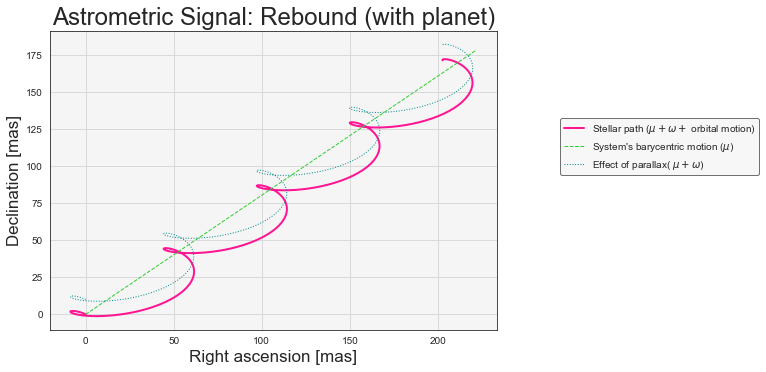

In [347]:
# plotting data 
# plt.plot(alpha_np*as_mas,         
#          (delta_np-delta_np[0])*as_mas,                 
#          color='violet',
#          lw=2, 
#          label='Stellar path (without planet)')

plt.plot(signal_wp[:,0]*as_mas,      
         (signal_wp[:,1]-signal_wp[0,1])*as_mas,           
         color='deeppink', 
         lw=2, 
         label='Stellar path ($\mu + \omega +$ orbital motion)')


plt.plot(proper_sim[:,0]*as_mas, 
         proper_sim[:,1]*as_mas, 
         color='limegreen',
         lw=1,
         ls = '--',
         label='System\'s barycentric motion ($\mu$)')

plt.plot(parallax_motion_sim[:,0]*as_mas, 
         parallax_motion_sim[:,1]*as_mas, 
         color='darkcyan', 
         label='Effect of parallax( $\mu + \omega $)', 
         lw=1,
         linestyle='dotted')


# set titles 
plt.title('Astrometric Signal: Rebound (with planet)'     , fontsize = 24)             
plt.xlabel('Right ascension [mas]' , fontsize = 17)                     
plt.ylabel('Declination [mas]'     , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.6, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.2 Equation plot

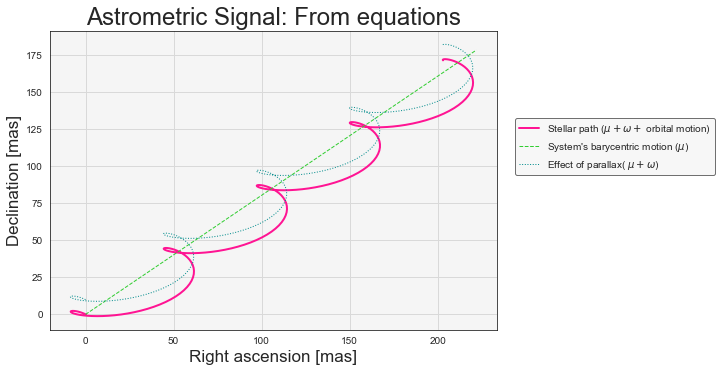

In [348]:
# plotting data 
plt.plot(three22*as_mas, 
         (three23-three23[0])*as_mas, 
         color='deeppink', 
         lw=2,
         label = 'Stellar path ($\mu + \omega +$ orbital motion)')

plt.plot(proper_motion[:,0]*as_mas, 
         proper_motion[:,1]*as_mas, 
         color='limegreen', 
         lw=1,           
         ls='--', 
         label = 'System\'s barycentric motion ($\mu$)')

plt.plot(parallax_motion[:,0]*as_mas, 
         parallax_motion[:,1]*as_mas, 
         color='darkcyan', 
         lw=1, 
         ls='dotted', 
         label = 'Effect of parallax( $\mu + \omega $)')


# set titles 
plt.title('Astrometric Signal: From equations'    , fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.3 Comparing proper motion RA and Dec

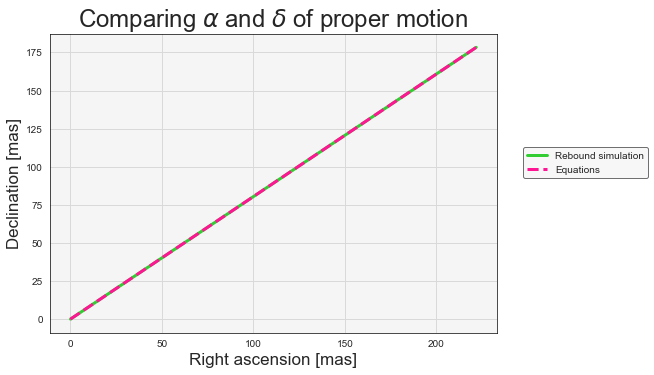

In [349]:
# plotting data 

plt.plot(proper_sim[:,0]*as_mas, 
         proper_sim[:,1]*as_mas, 
         color='limegreen',
         lw=3, 
         label='Rebound simulation') 

plt.plot(proper_motion[:,0]*as_mas  , 
         proper_motion[:,1]*as_mas  , 
         color='deeppink', 
         lw=3,
         ls='--', 
         label = 'Equations')

# set titles 
plt.title('Comparing $α$ and $\delta$ of proper motion', fontsize = 24)             
plt.xlabel('Right ascension [mas]' , fontsize = 17)                     
plt.ylabel('Declination [mas]'     , fontsize = 17)
  
# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.35, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.4 Comparing parallax

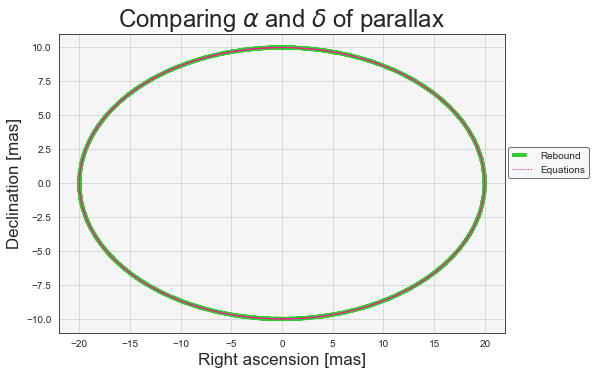

In [350]:
# plotting data 
plt.plot(parallax_sim[:,0]*as_mas, 
         parallax_sim[:,1]*as_mas, 
         color='limegreen',      
         lw=4,
         ls='--',
         label='Rebound')

plt.plot(parallax_only[:,0]*as_mas, 
         parallax_only[:,1]*as_mas, 
         color='deeppink', 
         label='Equations', 
         lw=1,
         linestyle='dotted')


# set titles 
plt.title('Comparing $α$ and $\delta$ of parallax '     , fontsize = 24)             
plt.xlabel('Right ascension [mas]' , fontsize = 17)                     
plt.ylabel('Declination [mas]'     , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.2, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

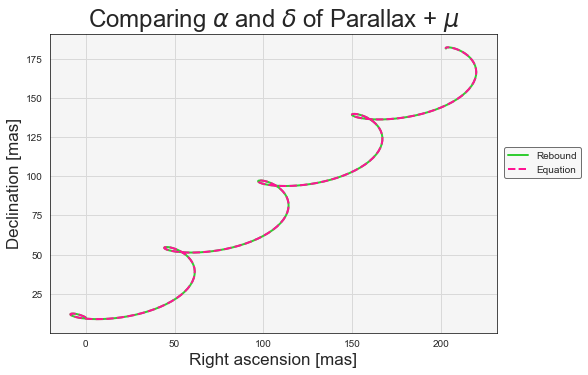

In [335]:
# plotting data 
plt.plot(parallax_motion_sim[:,0]*as_mas, 
         parallax_motion_sim[:,1]*as_mas, 
         color='limegreen', 
         label='Rebound', 
         lw=2)

plt.plot(parallax_motion[:,0]*as_mas, 
         parallax_motion[:,1]*as_mas, 
         color='deeppink', 
         label='Equation',
         lw=2,
         ls='--')

# set titles 
plt.title('Comparing $α$ and $\delta$ of Parallax + $\mu$'     , fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)
  
# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

#plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.2, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.5 Comparing orbital motion 

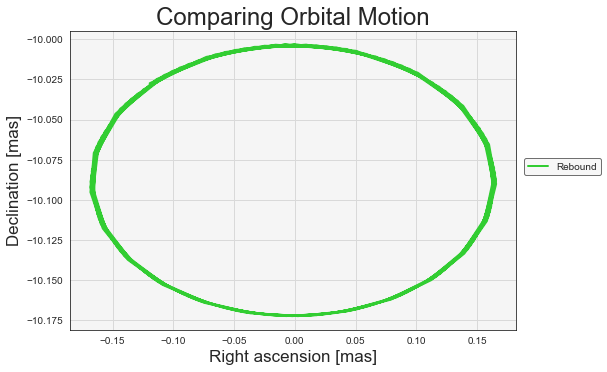

In [354]:
# plotting data 
plt.plot(orbital_motion_sim[:,0]*as_mas, 
         orbital_motion_sim[:,1]*as_mas, 
         color='limegreen', 
         label='Rebound', 
         lw=2)

# plt.plot(orbital_motion[:,0]*as_mas, 
#          orbital_motion[:,1]*as_mas, 
#          color='deeppink', 
#          label='Equation',
#          lw=2,
#          ls='--')

# set titles 
plt.title('Comparing Orbital Motion', fontsize = 24)             
plt.xlabel('Right ascension [mas]',  fontsize = 17)                     
plt.ylabel('Declination [mas]'    ,  fontsize = 17)
  
# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

#plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.2, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.6 Comparing astrometric signal of both methods

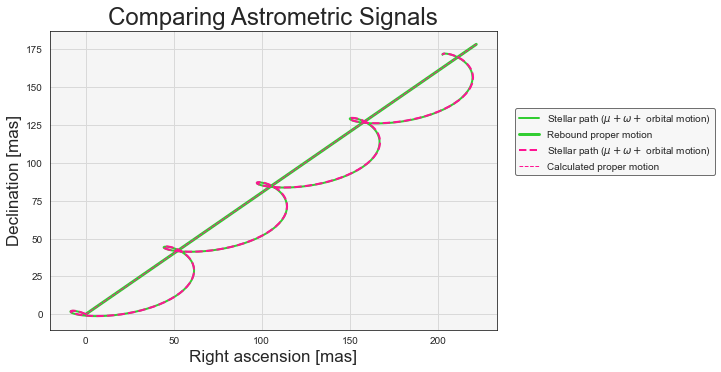

In [337]:
# plotting data 
plt.plot(signal_wp[:,0]*as_mas,      
         (signal_wp[:,1]-signal_wp[0,1])*as_mas,           
         color='limegreen', 
         lw=2, 
         label='Stellar path ($\mu + \omega +$ orbital motion)')

plt.plot(proper_sim[:,0]*as_mas, 
         proper_sim[:,1]*as_mas, 
         color='limegreen',
         lw=3, 
         label='Rebound proper motion') 

plt.plot(three22*as_mas, 
         (three23-three23[0])*as_mas, 
         color='deeppink', 
         lw=2,
         ls='--', 
         label = 'Stellar path ($\mu + \omega +$ orbital motion)')

plt.plot(proper_motion[:,0]*as_mas, 
         proper_motion[:,1]*as_mas, 
         color='deeppink', 
         lw=1, 
         ls='--', 
         label = 'Calculated proper motion')


# set titles 
plt.title('Comparing Astrometric Signals', fontsize = 24)             
plt.xlabel('Right ascension [mas]',        fontsize = 17)                     
plt.ylabel('Declination [mas]',            fontsize = 17)
  
# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)